In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso

import seaborn as sns

from math import sqrt
from scipy import stats

import matplotlib.pyplot as plt

sns.set(style = "darkgrid")
sns.set(rc={"figure.figsize":(15, 10)})

## Importando dados

##### Vamos utilizar as seguintes variáveis na nossa análise:
* Q001: Questão sobre o nível de escolaridade do pai do participante
* Q002: Questão sobre o nível de escolaridade da mãe do participante
* Q003: Questão sobre a ocupação do pai do participante
* Q004: Questão sobre a ocupação da mãe do participante
* Q005: Questão sobre quantas pessoas moram na residência do participante
* Q006: Questão sobre renda familiar do participante
* Q025: Questão sobre acesso a internet na residência do participante
* TP_ESCOLA: Tipo da escola que cursou o ensino médio
* NU_NOTA_CN: Nota da prova de ciências da natureza
* NU_NOTA_CH: Nota da prova de ciências humanas
* NU_NOTA_LC: Nota da prova de linguagens e códigos
* NU_NOTA_MT: Nota da prova de matemática
* NU_NOTA_REDACAO: Nota da prova de redação

In [2]:
cols = ["Q001", "Q002","Q003", "Q004", "Q005", "Q006", 
        "Q025",  "TP_ESCOLA", "NU_NOTA_CN", "NU_NOTA_CH", 
        "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]


df_raw = pd.read_csv("data/DADOS/MICRODADOS_ENEM_2019.csv",
                 sep = ";", 
                 usecols = cols, 
                 encoding="iso-8859-1")

print(df_raw.shape)
df_raw.head()

(5095270, 13)


,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q025
0,1,472.9,466.0,497.3,369.1,780.0,D,E,A,A,7,B,A
1,1,358.9,495.4,482.3,416.5,600.0,D,E,A,A,5,B,A
2,3,574.2,538.7,582.6,571.5,640.0,H,E,A,D,3,C,B
3,2,NaN,NaN,NaN,NaN,NaN,D,D,A,B,3,C,A
4,1,NaN,NaN,NaN,NaN,NaN,B,C,A,A,5,C,A


#### Renomeando e mapeando as variáveis

In [3]:
df_raw.rename(columns={"TP_ESCOLA":"TIPO_ESCOLA",
                       "Q001":"ESCOLARIDADE_PAI", 
                       "Q002":"ESCOLARIDADE_MAE",
                       "Q003":"OCUPACAO_PAI", 
                       "Q004":"OCUPACAO_MAE",
                       "Q005":"PESSOAS_RESIDENCIA",
                       "Q006":"RENDA_FAMILIAR",
                       "Q025":"INTERNET_RESIDENCIA", 
                       "NU_NOTA_CN":"CIENCIAS_NATUREZA", 
                       "NU_NOTA_CH":"CIENCIAS_HUMANAS", 
                       "NU_NOTA_LC":"LINGUAGENS_CODIGOS", 
                       "NU_NOTA_MT":"MATEMATICA",
                       "NU_NOTA_REDACAO":"REDACAO"}, 
          inplace=True)

map_tp_escola = {
    1: "Não_Respondeu",
    2: "Pública", 
    3: "Privada",
    4: "Exterior"
}
df_raw["TIPO_ESCOLA"] = df_raw["TIPO_ESCOLA"].map(lambda x: map_tp_escola[x])

map_escolaridade = {
    "A": "Nunca_estudou",
    "B": "Nao_completou_ens_fund1", 
    "C": "Nao_completou_ens_fund2",
    "D": "Nao_completou_ens_medio", 
    "E": "Completou_ens_medio",
    "F": "Completou_faculdade",
    "G": "Completou_pós_graduação",
    "H": "Não_sei"
}
df_raw["ESCOLARIDADE_PAI"] = df_raw["ESCOLARIDADE_PAI"].map(lambda x: map_escolaridade[x])
df_raw["ESCOLARIDADE_MAE"] = df_raw["ESCOLARIDADE_MAE"].map(lambda x: map_escolaridade[x])

map_ocupacao = {
    "A": "Grupo1",
    "B": "Grupo2", 
    "C": "Grupo3",
    "D": "Grupo4", 
    "E": "Grupo5",
    "F": "Não_sei"
}
df_raw["OCUPACAO_PAI"] = df_raw["OCUPACAO_PAI"].map(lambda x: map_ocupacao[x])
df_raw["OCUPACAO_MAE"] = df_raw["OCUPACAO_MAE"].map(lambda x: map_ocupacao[x])

map_internet = {
    "A": 0,
    "B": 1
}
df_raw["INTERNET_RESIDENCIA"] = df_raw["INTERNET_RESIDENCIA"].map(lambda x: map_internet[x])

df_raw.loc[df_raw["RENDA_FAMILIAR"].isin(["N", "O", "P", "Q"]), "CLASSE_ECONOMICA"] = "A_B"
df_raw.loc[df_raw["RENDA_FAMILIAR"].isin(["E", "F", "G", "H", "I", "J", "K", "L", "M"]), "CLASSE_ECONOMICA"] = "C_D"
df_raw.loc[df_raw["RENDA_FAMILIAR"].isin(["A", "B", "C", "D"]), "CLASSE_ECONOMICA"] = "E_Semrenda"

df_raw.drop(columns = ["RENDA_FAMILIAR"], inplace = True)

#### Tratando dados faltantes

* Iremos analisar apenas os participantes que possuam as 5 notas válidas, ou seja, aqueles que participaram de todas as provas, mais a redação.

In [4]:
df_raw.dropna(how = "any", 
              subset = ["CIENCIAS_NATUREZA", "CIENCIAS_HUMANAS", 
                        "LINGUAGENS_CODIGOS", "MATEMATICA", "REDACAO"], 
              inplace = True)

#### Criando a variável de nota média

In [5]:
df_raw["NOTA_MEDIA"] = (df_raw["CIENCIAS_NATUREZA"] + 
                        df_raw["CIENCIAS_HUMANAS"] + 
                        df_raw["LINGUAGENS_CODIGOS"] + 
                        df_raw["MATEMATICA"] + 
                        df_raw["REDACAO"])/5

#### Tratando variáveis categoricas
* Tranformando as variáveis categoricas em variáveis dummy

In [6]:
cat_cols = list(df_raw.select_dtypes(exclude = [np.number]).columns)

df = df_raw.copy()

for col in cat_cols:
    cols_gd = pd.get_dummies(df[col])

    new_cols_name = {n_col:col + "_" + n_col for n_col in cols_gd}
    cols_gd.rename(columns = new_cols_name, inplace = True)
    
    df = pd.concat([df, cols_gd], axis = 1)
    df.drop(columns = [col], inplace = True)
    
df.head()

,CIENCIAS_NATUREZA,CIENCIAS_HUMANAS,LINGUAGENS_CODIGOS,MATEMATICA,REDACAO,PESSOAS_RESIDENCIA,INTERNET_RESIDENCIA,NOTA_MEDIA,TIPO_ESCOLA_Não_Respondeu,TIPO_ESCOLA_Privada,...,OCUPACAO_PAI_Não_sei,OCUPACAO_MAE_Grupo1,OCUPACAO_MAE_Grupo2,OCUPACAO_MAE_Grupo3,OCUPACAO_MAE_Grupo4,OCUPACAO_MAE_Grupo5,OCUPACAO_MAE_Não_sei,CLASSE_ECONOMICA_A_B,CLASSE_ECONOMICA_C_D,CLASSE_ECONOMICA_E_Semrenda
0,472.9,466.0,497.3,369.1,780.0,7,0,517.06,1,0,...,0,1,0,0,0,0,0,0,0,1
1,358.9,495.4,482.3,416.5,600.0,5,0,470.62,1,0,...,0,1,0,0,0,0,0,0,0,1
2,574.2,538.7,582.6,571.5,640.0,3,1,581.40,0,1,...,0,0,0,0,1,0,0,0,0,1
5,522.0,592.6,582.0,605.3,580.0,5,0,576.38,1,0,...,0,0,0,0,1,0,0,0,0,1
6,407.4,480.1,464.3,581.5,360.0,4,1,458.66,1,0,...,0,1,0,0,0,0,0,0,0,1


#### Retirando os outliers

In [7]:
df = df[(np.abs(stats.zscore(df_raw[["NOTA_MEDIA"]])) < 3).all(axis=1)]

#### Normalizando a variável PESSOAS_RESIDENCIA

In [8]:
mm_s = MinMaxScaler()
df["PESSOAS_RESIDENCIA"] = mm_s.fit_transform(df[["PESSOAS_RESIDENCIA"]])

#### Dropando colunas irrelevantes para o modelo
* Dropamos as demais notas além da média, e também variáveis em que o participante não respondeu, ou não sabia

In [9]:
df.drop(columns = ["CIENCIAS_NATUREZA", "CIENCIAS_HUMANAS", 
                   "LINGUAGENS_CODIGOS", "MATEMATICA", "REDACAO", 
                   "TIPO_ESCOLA_Não_Respondeu", "ESCOLARIDADE_PAI_Não_sei", 
                   "ESCOLARIDADE_MAE_Não_sei", "OCUPACAO_PAI_Não_sei", 
                   "OCUPACAO_MAE_Não_sei"], 
        inplace = True)

#### Dividindo dataset

In [10]:
y = df["NOTA_MEDIA"].values
x = df.drop(columns=["NOTA_MEDIA"]).values

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state = 42)

print("Train size: %i"%(len(y_train)))
print("Test size: %i"%(len(y_test)))

Train size: 2587905
Test size: 1109103


#### Criando modelo

In [12]:
lasso = Lasso()
lasso.fit(x_train, y_train)

Lasso()

In [13]:
y_pred = lasso.predict(x_test)
print("Predicted:", y_pred)
print("Real:", y_test)
print("RMSE = %.2f"%(sqrt(mean_squared_error(y_test, y_pred))))

Predicted: [485.54401216 472.26379514 495.28823882 ... 477.12111457 499.40006735
 472.3829229 ]
Real: [442.18 484.18 471.5  ... 472.8  484.2  406.4 ]
RMSE = 71.26


### Análise dos coeficientes do modelo

In [14]:
x_cols = df.drop(columns=["NOTA_MEDIA"]).columns

coefs = pd.DataFrame(zip(x_cols, lasso.coef_), columns= ["var", "coef"])
coefs.sort_values("coef", ascending = False, inplace = True)
coefs

,var,coef
22,OCUPACAO_PAI_Grupo5,21.050370
28,CLASSE_ECONOMICA_A_B,20.663658
2,TIPO_ESCOLA_Privada,19.328940
1,INTERNET_RESIDENCIA,16.864732
21,OCUPACAO_PAI_Grupo4,16.556861
12,ESCOLARIDADE_MAE_Completou_faculdade,12.137430
13,ESCOLARIDADE_MAE_Completou_pós_graduação,11.793078
5,ESCOLARIDADE_PAI_Completou_faculdade,8.983358
26,OCUPACAO_MAE_Grupo4,8.280451
11,ESCOLARIDADE_MAE_Completou_ens_medio,3.677826


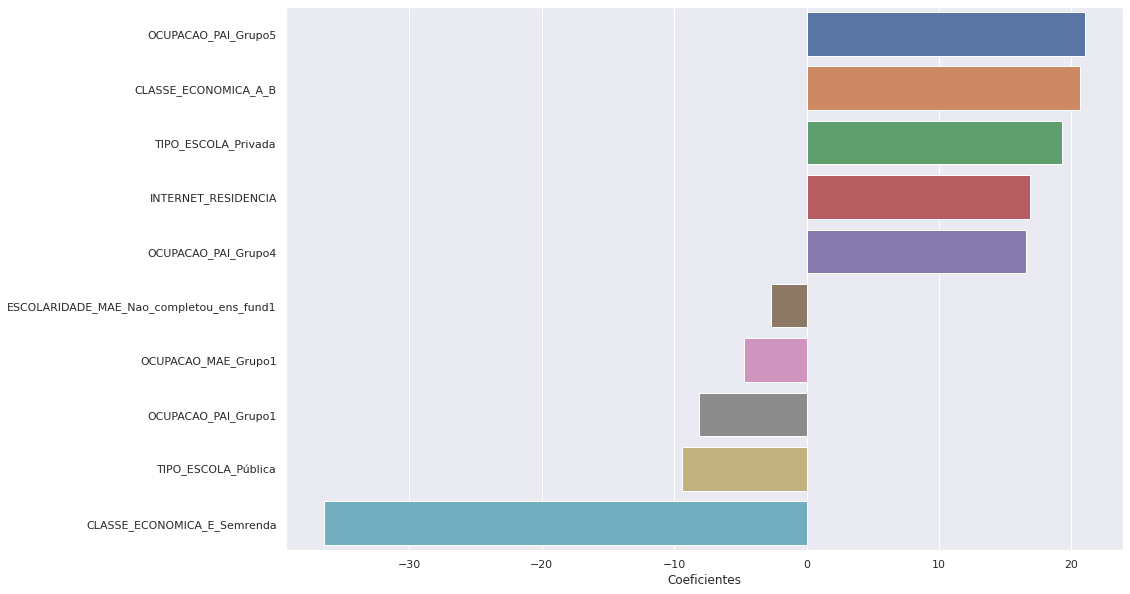

In [15]:
ax = sns.barplot(x = "coef", y = "var", data = pd.concat([coefs.head(), coefs.tail()]))

ax.set_ylabel("")
ax.set_xlabel("Coeficientes")

ax.figure.savefig("output_images/coefs.png", bbox_inches = "tight")

* Como vimos as variáveis com maiores coeficientes estão associados a ocupação do pai do participante, e também a classe ecônomica que ele está inserido. 
* Já vimos anteriormente, na análise exploratória, que de fato a classe econômica é um fator extremamente relevante no desempenho do estudante, tanto que no modelo é uma variável com um coeficiente muito positivo para as classes A e B, só que ainda muito mais negativo para as classes E e Sem renda. Dado isso, agora devemos analisar a variável relacionada à ocupação do pai do participante.

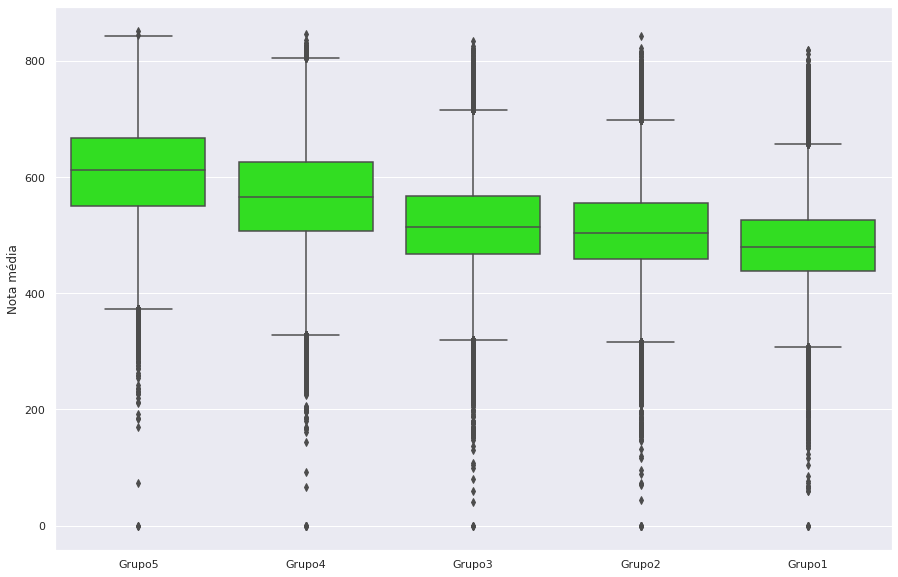

In [16]:
ax = sns.boxplot(x = "OCUPACAO_PAI", y = "NOTA_MEDIA", data = df_raw[df_raw["OCUPACAO_PAI"] != "Não_sei"], 
                 order = df_raw[df_raw["OCUPACAO_PAI"] != "Não_sei"].groupby("OCUPACAO_PAI").median()\
                         ["NOTA_MEDIA"].sort_values(ascending = False).keys(), 
                 color = "#18fc03")

ax.set_ylabel("Nota média")
ax.set_xlabel("")

ax.figure.savefig("output_images/boxplot_ocupacao_pai.png", bbox_inches = "tight")

* Está visivel que estudantes com pais inclusos no grupo 5 ou no grupo 4 têm maiores probabilidades de alcançarem as melhores notas, por isso essas respostas possuem coeficientes positivos tão altos, enquanto os estudantes com pais no grupo 1 alcançam notas consideravelmente menores que os demais. Isso só demonstra mais o quanto a disparidade social afeta no desempenho dos estudantes, já que os grupos são organizados de forma que os empregos mais almejados, coincidentalmente os mais bem remunerados, fiquem acima dos outros.